In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from sympy import cos, sin, exp

# Geração de sinais ópticos

Num sistema de comunicação digital óptica, a função do transmissor é converter uma dada sequência de bits num trem de pulsos elétricos que, por sua vez, será utilizado na modulação de uma portadora óptica (laser). A modulação de portadoras ópticas é realizada por meio de dispositivos de conversão eletro-óptica.

Diversas técnicas de modulação podem ser implementadaas e diversos fatores podem influenciar o projeto de um transmissor óptico. 

## Formatos de modulação

$\mathbf{E}(t)=\hat{\mathbf{e}} A_{0} \cos \left(\omega_{0} t-\phi_{0}\right)$

In [2]:
ϕ0, omega0, A0, t = sp.symbols('ϕ0, omega0, A0, t', real=True)

j = sp.I

E = A0*cos(omega0*t - ϕ0)
E

A0*cos(omega0*t - ϕ0)

$\mathbf{E}(t)=\operatorname{Re}\left[\hat{\mathbf{e}} A_{0} e^{j \phi_{0}} \exp \left(-j \omega_{0} t\right)\right]$

In [3]:
sp.re(A0*exp(j*ϕ0)*exp(-j*omega0*t)).simplify()

A0*cos(omega0*t - ϕ0)

In [4]:
sp.expand_trig(E).cancel()

A0*sin(ϕ0)*sin(omega0*t) + A0*cos(ϕ0)*cos(omega0*t)

### Chaveamento por deslocamento de amplitude (*amplitude shift-keing* - ASK) ou modulação de amplitude de pulso (*pulse amplitude modulation* - PAM)

$ E(t)=\operatorname{Re}\left[A_{0}(t) e^{j \phi_{0}} \exp \left(-j \omega_{0} t\right)\right]$

$ A_{0}(t)=\sqrt{P_{0}} \sum_{n} b_{n} p\left(t-n T_{s}\right)$

In [5]:
from commpy.modulation import Modem, QAMModem
from commpy.utilities  import signal_power, upsample
from utils.dsp import firFilter, pulseShape, eyediagram

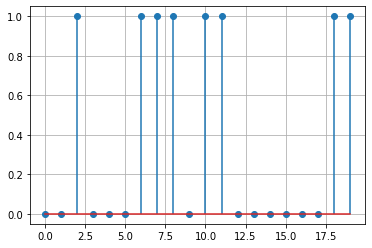

In [6]:
# parâmetros da simulação
SpS = 32

Rs     = 10e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem
P0     = 1             # Potência
    
# gera sequência de bits pseudo-aleatórios
bits   = np.random.randint(2, size=20)    
n      = np.arange(0, bits.size)

# mapeia bits para símbolos OOK
symbTx = np.sqrt(P0)*bits

plt.figure(1)
plt.stem(symbTx, use_line_collection=True)
plt.grid()

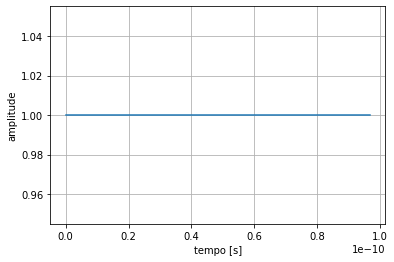

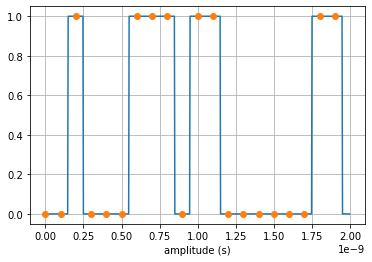

In [7]:
# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso retangular ideal
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

t = np.arange(0, pulse.size)*Ta

plt.figure(1)
plt.plot(t, pulse,'-', label = 'pulso')
plt.xlabel('tempo [s]')
plt.ylabel('amplitude')
plt.grid()

# formatação de pulso retangular
sigTx  = firFilter(pulse, symbolsUp)

t = np.arange(0, sigTx.size)*Ta

symbolsUp = upsample(2*bits-1, SpS)
symbolsUp[symbolsUp==0] = np.nan
symbolsUp = (symbolsUp + 1)/2

plt.figure(2)
plt.plot(t, sigTx.real,'-')
plt.plot(t, symbolsUp.real,'o')
plt.xlabel('tempo (s)')
plt.ylabel('amplitude (s)')
plt.grid()

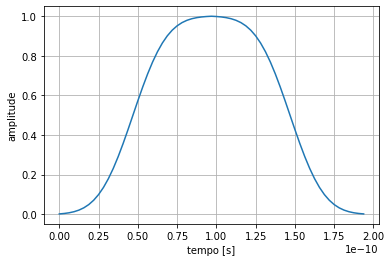

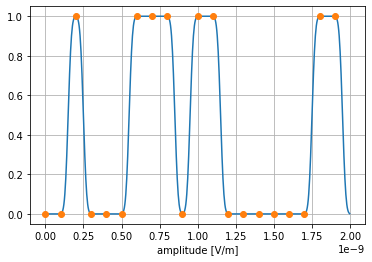

In [8]:
# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

t = np.arange(0, pulse.size)*Ta

plt.figure(1)
plt.plot(t, pulse,'-', label = 'pulso')
plt.xlabel('tempo [s]')
plt.ylabel('amplitude')
plt.grid()

# upsampling
symbolsUp = upsample(symbTx, SpS)

# formatação de pulso retangular
sigTx  = firFilter(pulse, symbolsUp)

t = np.arange(0, sigTx.size)*Ta

symbolsUp = upsample(2*bits-1, SpS)
symbolsUp[symbolsUp==0] = np.nan
symbolsUp = (symbolsUp + 1)/2

plt.figure(2)
plt.plot(t, sigTx.real,'-')
plt.plot(t, symbolsUp.real,'o')
plt.xlabel('tempo [s]')
plt.ylabel('amplitude [V/m]')
plt.grid()

## Espectro do sinal modulado

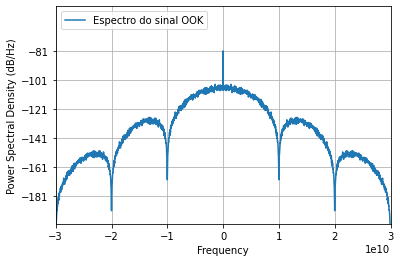

In [9]:
# gera sequência de bits pseudo-aleatórios
bits   = np.random.randint(2, size=10000)    
n      = np.arange(0, bits.size)

# mapeia bits para símbolos OOK
symbTx = np.sqrt(P0)*bits

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# plot spectrums
plt.figure();
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal OOK')
plt.legend(loc='upper left');
plt.xlim(-3*Rs,3*Rs);
plt.ylim(-200,-50);

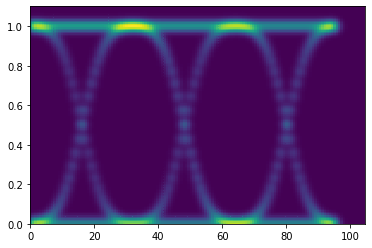

In [11]:
Nsamples = 20000

# diagrama de olho
eyediagram(sigTx, Nsamples, SpS, n=3)

### PAM4

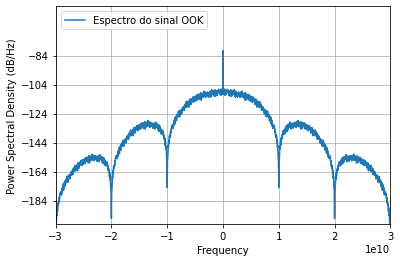

In [24]:
# gera sequência de bits pseudo-aleatórios
bits1   = np.random.randint(2, size=10000)  
bits2   = np.random.randint(2, size=10000) 

n      = np.arange(0, bits.size)

# mapeia bits para símbolos PAM4
symbTx = np.sqrt(P0)*((2/3)*bits1 + (1/3)*bits2)

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# plot spectrums
plt.figure();
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal OOK')
plt.legend(loc='upper left');
plt.xlim(-3*Rs,3*Rs);
plt.ylim(-200,-50);

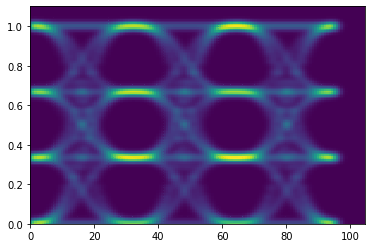

In [25]:
Nsamples = 20000

# diagrama de olho
eyediagram(sigTx, Nsamples, SpS, n=3)